### Init

In [1]:
from dotenv import load_dotenv
from lib.seed import seed_prefix 
import sys, os 
load_dotenv()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [2]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
mask_dir = os.getenv('MEDSAM1_MASK_DIR')
train_df, test_df = data_split(data_df, split_num = 5)
binary_use = False
num_classes = 3

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


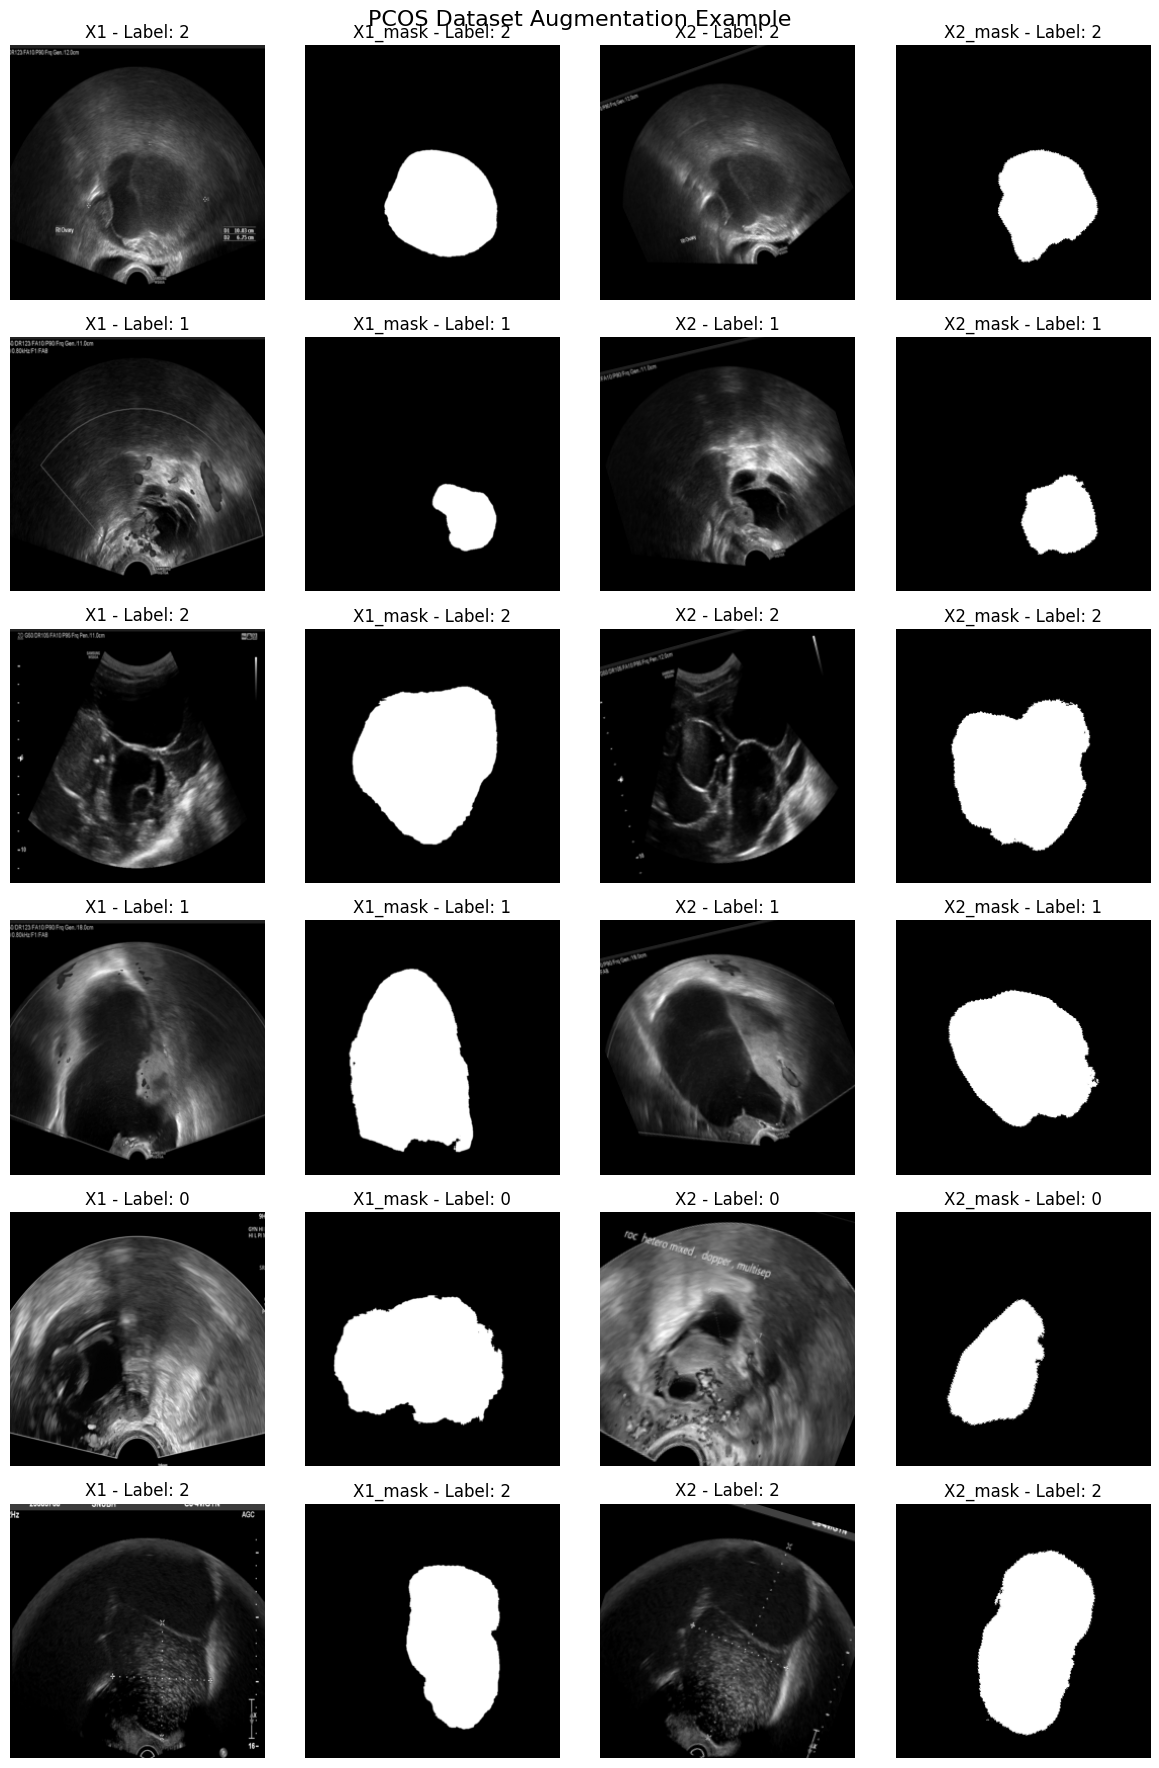

In [3]:
from lib.dataset import PCOS_Syntheis_Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader

train_dataset = PCOS_Syntheis_Dataset(
    df = train_df, 
    data_filenames = train_df['filename'],
    data_dir_path  = data_dir,
    mask_dir_path = mask_dir,
    labels         = train_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    need_paths = True,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.Grayscale(num_output_channels=1),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환  [0, 255] -> [0.0, 1.0]
        # v2.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]),
    mask_transform= v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.ToTensor(),                # 텐서 변환
    ]),
    affine_transform_use = True
)

from lib.sampler import BalancedBatchSampler, IterationBasedBatchSampler
import torch 
train_bs = 9
# total_num_iteration = 100
# sampler = torch.utils.data.RandomSampler(train_dataset)
# batch_sampler = torch.utils.data.sampler.BatchSampler(sampler=sampler, batch_size=train_bs, drop_last=True)
# batch_sampler = IterationBasedBatchSampler(batch_sampler, num_iterations=total_num_iteration)

train_loader = DataLoader(
    train_dataset,
    batch_size = train_bs,
    # shuffle = True,
    sampler= BalancedBatchSampler(
        dataset = train_dataset,
        labels = train_dataset.labels,
        batch_size = train_bs,
    ),
    pin_memory=True,
    pin_memory_device= "cuda:0",
    persistent_workers=True,
    prefetch_factor = 8,
    num_workers= 16,
)
#%% Train Augmentation
X1, X1_mask, y, X2, X2_mask, paths = next(iter(train_loader))
# X, y, paths = next(iter(train_loader))

import matplotlib.pyplot as plt
try:
    fig, axes = plt.subplots(6, 4, figsize=(12, 18))
    fig.suptitle('PCOS Dataset Augmentation Example', fontsize=16)

    for i in range(6):
        axes[i, 0].imshow(X1[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 0].set_title(f'X1 - Label: {y[i].item():.0f}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(X1_mask[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 1].set_title(f'X1_mask - Label: {y[i].item():.0f}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(X2[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 2].set_title(f'X2 - Label: {y[i].item():.0f}')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(X2_mask[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 3].set_title(f'X2_mask - Label: {y[i].item():.0f}')
        axes[i, 3].axis('off')
except Exception as e:
    pass
    print(f"Error during visualization: {e}")

plt.tight_layout()
plt.show()

In [4]:
import torch 
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Optimize, Loss 정의

In [5]:
MSELoss = torch.nn.MSELoss()
L1Loss = torch.nn.L1Loss()

def MSErealTargetLoss(x):
    target = torch.cuda.FloatTensor(x.shape[0], 1).fill_(1.0)
    return MSELoss(x, target)
    

def MSEfakeTargetLoss(x):
    target = torch.cuda.FloatTensor(x.shape[0], 1).fill_(0.0)
    return MSELoss(x, target)


def cycleLoss(a, a_):
    return L1Loss(a, a_)


# play Buffer -- A trick for CycleGAN Optimization
import random 
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0)
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

### 실험 정의

In [6]:
from lib.sampler import IterationBasedBatchSampler
from lib.utils import * 

# LambdaLR Scheduler Definition

class LambdaLR():
    def __init__(self, n_total, decay_start):
        assert ((n_total - decay_start) > 0), "Decay must start before the training session ends!"
        self.n_total = n_total
        self.decay_start = decay_start

    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start)/(self.n_total - self.decay_start)
    

#### [Settings] Train - Hyper Parmas 정의

In [7]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime
import itertools

### Model Load

In [8]:
# Initialize generators and discriminators
# Training Configs
lr_init = 42e-9
save_epoch = 1
train_epoch = 100
total_num_iteration = 10

from models import Model_Loader
model = Model_Loader(model_name = 'CycleGAN', num_classes = 1)

Gen = model['G']
Dis = model['D']

genS2W = Gen(input_nc = 1, output_nc = 1) 
genW2S = Gen(input_nc = 1, output_nc = 1)
disS = Dis(input_nc = 1)
disW = Dis(input_nc = 1)

genS2W.apply(weights_init)
genW2S.apply(weights_init)
disS.apply(weights_init)
disW.apply(weights_init)

genS2W.cuda()
genW2S.cuda()
disS.cuda()
disW.cuda()

import tqdm 

# Optimizers & LR schedulers
# optG = torch.optim.Adam(itertools.chain(genS2W.parameters(), genW2S.parameters()), lr=lr_init, betas=(0.5, 0.999))
# optD_S = torch.optim.Adam(disS.parameters(), lr=lr_init, betas=(0.5, 0.999))
# optD_W = torch.optim.Adam(disW.parameters(), lr=lr_init, betas=(0.5, 0.999))

optG = torch.optim.AdamW(itertools.chain(genS2W.parameters(), genW2S.parameters()), lr=lr_init)
optD_S = torch.optim.Adam(disS.parameters(), lr=lr_init)
optD_W = torch.optim.Adam(disW.parameters(), lr=lr_init)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optG, lr_lambda=LambdaLR(total_num_iteration, total_num_iteration//1.5).step)
lr_scheduler_D_S = torch.optim.lr_scheduler.LambdaLR(optD_S, lr_lambda=LambdaLR(total_num_iteration, total_num_iteration//1.5).step)
lr_scheduler_D_W = torch.optim.lr_scheduler.LambdaLR(optD_W, lr_lambda=LambdaLR(total_num_iteration, total_num_iteration//1.5).step)

fake_S_buffer = ReplayBuffer()
fake_W_buffer = ReplayBuffer()


In [9]:
from torch.utils.tensorboard import SummaryWriter
log_dir = './log/cyclegan_512'
writer = SummaryWriter(log_dir)  # specify directory to store visualization outputs

In [10]:

for epoch_iter, epoch in enumerate(range(train_epoch)):
    print(f"Epoch {epoch+1}/{train_epoch}") 
    for iteration, (S_imgs, S_masks, labels, W_imgs, W_masks, paths) in tqdm.tqdm(enumerate(train_loader), desc = "Training Time per Epoch", total = len(train_loader)):
        """
        Input : S_imgs <-> W_masks
        """
        # S_imgs, S_masks, W_imgs, W_masks = S_imgs.cuda(), S_masks.cuda(), W_imgs.cuda(), W_masks.cuda()
        ### [Input] S_input : S_imgs 2채널 + S_masks 1채널 / W_input : W_imgs 2채널 + W_masks 1채널
        # S_inputs = torch.cat([S_imgs[:, :2], S_masks], dim=1).cuda()
        # W_inputs = torch.cat([W_imgs[:, :2], W_masks], dim=1).cuda()
        # S_inputs = torch.cat([S_imgs, S_masks], dim = 1)
        # W_inputs = torch.cat([W_imgs, W_masks], dim = 1)
        S_imgs = S_imgs.cuda()
        W_imgs = W_imgs.cuda()
        
        optG.zero_grad()
        
        # Summer to Winter, then Winter to Summer
        identity_W = genS2W(W_imgs)
        faked_W = genS2W(S_imgs) 
        # faked_W_res = torch.cat([faked_W, W_masks], dim = 1)
        restored_S = genW2S(faked_W)
        
        # Winter to Summer, then Summer to Winter
        identity_S = genW2S(S_imgs)
        faked_S = genW2S(W_imgs) 
        # faked_S_res = torch.cat([faked_S, S_masks], dim = 1)
        restored_W = genS2W(faked_S)

        # compute Adv and cyclic losses, and their updates
        AdvLossS = MSErealTargetLoss(disS(faked_S))
        AdvLossW = MSErealTargetLoss(disW(faked_W))
        CycleLoss1 = cycleLoss(S_imgs, restored_S) * 10.0
        CycleLoss2 = cycleLoss(W_imgs, restored_W) * 10.0
        loss_G = AdvLossS + AdvLossW + CycleLoss1 + CycleLoss2
        loss_G.backward()
        optG.step()

        # Dis losses and their updates
        optD_S.zero_grad()
        DisLossS = (MSEfakeTargetLoss(disS(fake_S_buffer.push_and_pop(faked_S).detach())) + MSErealTargetLoss(disS(S_imgs))) * 0.5
        DisLossS.backward()
        optD_S.step()

        optD_W.zero_grad()
        DisLossW = (MSEfakeTargetLoss(disW(fake_W_buffer.push_and_pop(faked_W).detach())) + MSErealTargetLoss(disW(W_imgs))) * 0.5
        DisLossW.backward()
        optD_W.step()
        
        cntAdvLoss = AdvLossS.item() + AdvLossW.item()
        cntCycleLoss = CycleLoss1.item() + CycleLoss2.item()
        cntGenLoss = loss_G.item()
        
        cntDisLossS = DisLossS.item()
        cntDisLossW = DisLossW.item()
        cntDisLoss = cntDisLossS + cntDisLossW
        
        # Log training procedure
        writer.add_scalar('AdvLoss', cntAdvLoss, iteration+1)
        writer.add_scalar('CycleLoss', cntCycleLoss, iteration+1)
        writer.add_scalar('Loss_G', cntGenLoss, iteration+1)
        
        writer.add_scalar('DisLossS', cntDisLossS, iteration+1)
        writer.add_scalar('DisLossW', cntDisLossW, iteration+1)
        writer.add_scalar('Loss_D', cntDisLoss, iteration+1)
        
        
        lr_scheduler_G.step()
        lr_scheduler_D_S.step()
        lr_scheduler_D_W.step()

    # Save model and outputs
    if (epoch_iter+1) % save_epoch == 0:
        genS2W.save(f'{log_dir}/s2w_' + "%03d" % (epoch_iter+1) + '.pth')
        genW2S.save(f'{log_dir}/w2s_' + "%03d" % (epoch_iter+1) + '.pth')
        
    print('Training Completed. \n')

Epoch 1/100


Training Time per Epoch:   0%|          | 0/556 [00:00<?, ?it/s]

/tmp/ipykernel_1000403/286488331.py:5: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  target = torch.cuda.FloatTensor(x.shape[0], 1).fill_(1.0)
Training Time per Epoch: 100%|██████████| 556/556 [03:48<00:00,  2.44it/s]


Training Completed. 

Epoch 2/100


Training Time per Epoch: 100%|██████████| 556/556 [03:48<00:00,  2.43it/s]


Training Completed. 

Epoch 3/100


Training Time per Epoch: 100%|██████████| 556/556 [03:48<00:00,  2.44it/s]


Training Completed. 

Epoch 4/100


Training Time per Epoch: 100%|██████████| 556/556 [03:48<00:00,  2.44it/s]


Training Completed. 

Epoch 5/100


Training Time per Epoch: 100%|██████████| 556/556 [03:48<00:00,  2.44it/s]


Training Completed. 

Epoch 6/100


Training Time per Epoch: 100%|██████████| 556/556 [03:49<00:00,  2.43it/s]


Training Completed. 

Epoch 7/100


Training Time per Epoch:  28%|██▊       | 157/556 [01:04<02:45,  2.42it/s]


KeyboardInterrupt: 

#### Inference

In [ ]:
from lib.dataset import PCOS_Syntheis_Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
test_bs = 1

test_dataset = PCOS_Syntheis_Dataset(
    df = test_df, 
    data_filenames = test_df['filename'],
    data_dir_path  = data_dir,
    mask_dir_path = mask_dir,
    labels         = test_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    need_paths = True,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.Grayscale(num_output_channels=1),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환  [0, 255] -> [0.0, 1.0]

    ]),
    mask_transform= v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.ToTensor(),                # 텐서 변환
    ]),
    affine_transform_use = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = test_bs,
    shuffle = False,
    # sampler= BalancedBatchSampler(
    #     dataset = test_dataset,
    #     labels = test_dataset.labels,
    #     batch_size = test_bs,
    # ),
    pin_memory=True,
    pin_memory_device= "cuda:0",
    persistent_workers=True,
    prefetch_factor = 4,
    num_workers= 8,
)

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Inference Configs
img_size = 1024  # inference at resolution of 1024 x 1024
img_num = 1335
model_path = 'log/cyclegan_512/s2w_002376.pth'

store_dir = 'log/cyclegan_512/s2w_002376' 

os.makedirs(store_dir, exist_ok=True)   

Training Time per Epoch:   0%|          | 0/592 [00:00<?, ?it/s]

torch.Size([1, 1, 512, 512])


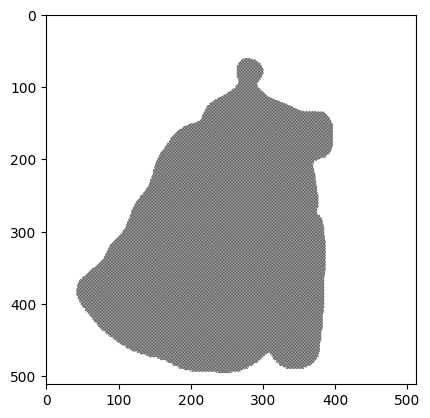

In [ ]:
import cv2
model = Gen(input_nc = 2, output_nc = 1).cuda()
model.load(model_path)
model.eval()

for iteration, (S_imgs, S_masks, labels, W_imgs, W_masks, paths) in tqdm.tqdm(enumerate(test_loader), desc = "Training Time per Epoch", total = len(test_loader)):
    with torch.no_grad():
        S_imgs, S_masks, W_imgs, W_masks = S_imgs.cuda(), S_masks.cuda(), W_imgs.cuda(), W_masks.cuda()
        S_inputs = torch.cat([W_imgs, S_masks], dim = 1)
        faked_W = model(S_inputs)
        print(faked_W.shape)
        faked_W = faked_W.cpu().detach().numpy()
        plt.imshow(faked_W.squeeze(), cmap = 'gray')
        break 
        # for i in range(len(restored_S)):
        #     restored_S_img = restored_S[i].squeeze()
        #     restored_S_img = (restored_S_img * 255).astype(np.uint8)
        #     cv2.imwrite(f'{store_dir}/{paths[i]}', restored_S_img)

    